In [1]:
# We will be implementing Recursive PSO in this notebook
import pickle
import numpy as np
import random

# Loading the database
X = pickle.load(open('input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('input_output.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

# A function to return the index of the input in the database
def input_index(Xinput):
  for i, input in enumerate(X):
    if np.array_equal(Xinput, input):
      return y[i]
  return None

shape of X: (25877, 151)
shape of y: (25877,)


In [2]:
def objective_function(x):
    x = np.array(x)

    # Finding the closest data point in the dataset
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    return y[closest_index]

# snap_position essentially snaps the input to the point in the database closest to it
def snap_position(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    snapped_input = X[closest_index]
    return snapped_input

def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

class Particle:
    def __init__(self, num_dimensions, lower_bound, upper_bound, init_position, index):
        self.position = init_position
        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = objective_function(self.best_position)
        self.index = index
        self.positions_traversed = [closest_index(init_position)]

class Cluster:
    def __init__(self, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, cluster_index, init_particle_positions, w_particle, c1_particle, c2_particle):
        self.particles = [Particle(num_dimensions, lower_bound, upper_bound, init_particle_positions[ind], ind) for ind in range(num_particles_in_cluster)]

        # Initial Position of the cluster is the average of the positions of all of the particles within that cluster
        init_cluster_position = np.zeros(num_dimensions)
        for particle in self.particles:
            init_cluster_position = np.add(init_cluster_position, particle.position)

        init_cluster_position = (init_cluster_position / num_particles_in_cluster)
        self.position = init_cluster_position

        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = y[closest_index(self.best_position)]

        # To determine the best particle within the cluster:

        self.in_cluster_best_position = self.particles[0].position
        for particle in self.particles:
            if( objective_function(particle.position) > objective_function(self.in_cluster_best_position) ):
                self.in_cluster_best_position = particle.position

        #self.in_cluster_best_position will now have the best particle within the cluster's position
        self.in_cluster_best_fitness = objective_function(self.in_cluster_best_position)

        self.w_particle = w_particle
        self.c1_particle = c1_particle
        self.c2_particle = c2_particle

        self.index = cluster_index

        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        self.positions_traversed = [closest_index(self.position)]

    def update_particles(self):
        for particle in self.particles:
            # Update velocities
            particle.velocity = (self.w_particle * particle.velocity
                                 + self.c1_particle * (particle.best_position - particle.position)
                                 + self.c2_particle * (self.in_cluster_best_position - particle.position))

            if(np.linalg.norm(particle.velocity) > 1.5):
                #print("old norm: ", np.linalg.norm(particle.velocity))
                particle.velocity = ((particle.velocity / np.linalg.norm(particle.velocity)) * 1.5)
                #print("new norm: ", np.linalg.norm(particle.velocity))

            particle.position = particle.position + particle.velocity + self.velocity # We need to move the particles along with the cluster too!

            particle.position = np.clip(particle.position, self.lower_bound, self.upper_bound)
            particle.position = snap_position(particle.position)
            particle.positions_traversed.append(closest_index(particle.position))

    def update_bests_particle(self):
        for particle in self.particles:
            current_fitness = objective_function(particle.position)

            if current_fitness > particle.best_fitness:
                particle.best_position = np.copy(particle.position)
                particle.best_fitness = current_fitness

                if current_fitness > self.in_cluster_best_fitness:
                    self.in_cluster_best_position = np.copy(particle.position)
                    self.in_cluster_best_fitness = current_fitness



class PSO:
    def __init__(self, num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, init_positions):
        self.num_clusters = num_clusters
        self.num_dimensions = num_dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.w_cluster = w_cluster
        self.c1_cluster = c1_cluster
        self.c2_cluster= c2_cluster
        self.num_iterations = num_iterations
        # def __init__(self, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, cluster_index, init_particle_positions, w_particle, c1_particle, c2_particle):
        self.clusters = [Cluster(num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, ind, init_positions[ind], w_particle, c1_particle, c2_particle) for ind in range(num_clusters)]

        self.global_best_cluster_position = self.clusters[0].position
        self.global_best_cluster_fitness = 0.0

        for cluster in self.clusters:
            if( y[closest_index(cluster.position)] > y[closest_index(self.global_best_cluster_position)] ):
                self.global_best_cluster_position = cluster.position

        self.global_best_cluster_fitness = y[closest_index(self.global_best_cluster_position)]

        self.global_best_position = np.zeros(num_dimensions)
        self.global_best_fitness = 0.0

        self.unique_function_call_ids = []
        self.global_max_for_each_unique_function_call = []

    def update_clusters(self):
        for cluster in self.clusters:

            # Update velocities
            cluster.velocity = (self.w_cluster * cluster.velocity
                                 + self.c1_cluster * np.random.rand() * (cluster.best_position - cluster.position)
                                 + self.c2_cluster * np.random.rand() * (self.global_best_cluster_position - cluster.position))

            if(np.linalg.norm(cluster.velocity) > 1.5):
                cluster.velocity = ((cluster.velocity / np.linalg.norm(cluster.velocity)) * 1.5)

            #print("cluster.velocity: ", cluster.velocity)
            cluster.position = cluster.position + cluster.velocity

            cluster.position = np.clip(cluster.position, self.lower_bound, self.upper_bound)
            cluster.position = snap_position(cluster.position)
            cluster.positions_traversed.append(closest_index(cluster.position))

    def update_bests_cluster(self):
        # Updating each individual cluster's information
        for cluster in self.clusters:
            current_fitness = y[closest_index(cluster.position)]

            if current_fitness > cluster.best_fitness:
                cluster.best_position = np.copy(cluster.position)
                cluster.best_fitness = current_fitness

                if current_fitness > self.global_best_cluster_fitness:
                    self.global_best_cluster_position = np.copy(cluster.position)
                    self.global_best_cluster_fitness = current_fitness


    def update_global_bests(self):
        for cluster in self.clusters:
            if( y[closest_index(cluster.position)] > y[closest_index(self.global_best_position)] ):
                self.global_best_position = cluster.position

            for particle in cluster.particles:
                if( y[closest_index(particle.position)] > y[closest_index(self.global_best_position)] ):
                    self.global_best_position = particle.position

        self.global_best_fitness = y[closest_index(self.global_best_position)]

    def update_unique_function_call_ids(self):
        for cluster in self.clusters:
            if closest_index(cluster.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(cluster.position))

            for particle in cluster.particles:
                if closest_index(particle.position) not in self.unique_function_call_ids:
                    self.unique_function_call_ids.append(closest_index(particle.position))

    def generate_global_max_for_each_unique_function_call(self):
        self.global_max_for_each_unique_function_call.append(y[self.unique_function_call_ids[0]])
        for i in range(1, len(self.unique_function_call_ids)):
            if( y[self.unique_function_call_ids[i]] > self.global_max_for_each_unique_function_call[ (i - 1) ] ):
                self.global_max_for_each_unique_function_call.append(y[self.unique_function_call_ids[i]])
            else:
                self.global_max_for_each_unique_function_call.append(self.global_max_for_each_unique_function_call[ (i - 1) ])


    def optimize(self):
      #for particle in self.particles:
        #   if closest_index(particle.position) not in self.unique_function_call_ids:
        #        self.unique_function_call_ids.append(closest_index(particle.position))
        #    if particle.best_fitness > self.global_best_fitness:
        #        self.global_best_position = np.copy(particle.position)
        #        self.global_best_fitness = particle.best_fitness
        #        self.global_max_for_each_unique_function_call.append(self.global_best_fitness)
        self.update_unique_function_call_ids()
        for i in range(self.num_iterations):

            self.update_clusters()
            self.update_bests_cluster()
            for cluster in self.clusters:
                cluster.update_particles()
                cluster.update_bests_particle()

            self.update_global_bests()
            self.update_unique_function_call_ids()


        all_positions_traversed_particles = []
        all_positions_traversed_clusters = []

        for cluster in self.clusters:
            all_positions_traversed_clusters.append(cluster.positions_traversed)
            for particle in cluster.particles:
                all_positions_traversed_particles.append(particle.positions_traversed)

        self.generate_global_max_for_each_unique_function_call()

        return self.global_best_position, self.global_best_fitness, all_positions_traversed_clusters, all_positions_traversed_particles, self.unique_function_call_ids, self.global_max_for_each_unique_function_call

# num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, init_positions
num_clusters = 5
num_particles_in_cluster = 10
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w_cluster = 0.5
c1_cluster = 0.5
c2_cluster = 0.5
w_particle = 1.0
c1_particle = 1.0
c2_particle = 1.0
num_iterations = 10

import numpy as np

def generate_arrays_within_distance(arr, num, distance):
    arrays = []
    arrays_indices = []
    arr = np.array(arr)

    #print("Beginning generate_arrays_within_distance.")
    #print("Current arr: ", arr)

    for i in range(num):
        while True:
            # Generating a random array within a specified distance
            rand_addition = (10.0 / num_dimensions) * np.random.uniform(-(distance), (distance), size=arr.shape)
            #print("rand_addition: ", rand_addition)
            #print("Norm: ", np.linalg.norm(rand_addition))
            rand_arr = arr + rand_addition
            #print("Rand_arr: ", rand_arr)
            #print("Index: ", closest_index(rand_arr))
            # Check if the distance is within the specified limit
            if (np.linalg.norm(rand_arr - arr) < distance and closest_index(rand_arr) not in arrays_indices):
                arrays.append(X[closest_index(rand_arr)])
                arrays_indices.append(closest_index(rand_arr))
                break  # Move on to the next array

            #print("Failed!")

    return arrays

# We'll choose a small radius, say 0.2
initial_cluster_centers = random.choices(X, k=num_clusters)
initial_positions_PSO = []
for i in range(num_clusters):
    #Fix THIS!
    #temp_arr = generate_arrays_within_distance(initial_cluster_centers[i], num_particles_in_cluster, 0.5)
    temp_arr = random.choices(X, k=num_particles_in_cluster)
    initial_positions_PSO.append(temp_arr)

print("Initial Positions: \n", initial_positions_PSO)


# num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, init_positions
pso = PSO(num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions_cluster, all_positions_particle, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions (Cluster): ", all_positions_cluster)
print("All_positions (Particle): ", all_positions_particle)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)


Initial Positions: 
 [[array([1.        , 0.00301802, 0.        , 0.15272067, 0.0309564 ,
       0.00228541, 0.33333333, 0.3010765 , 0.25686818, 0.23210454,
       0.2226186 , 0.21566716, 0.52688172, 0.66666667, 0.52434457,
       0.8172043 , 0.15053763, 0.52688172, 0.51666667, 0.70103093,
       0.52865497, 0.81188119, 0.14      , 0.51666667, 0.49423143,
       0.6635741 , 0.51533873, 0.78689427, 0.12332017, 0.49423143,
       0.35751122, 0.63578534, 0.48236411, 0.71541012, 0.07962478,
       0.35751122, 0.47058824, 0.70588235, 0.5       , 0.82352941,
       0.11764706, 0.47058824, 0.66666667, 0.5       , 0.5       ,
       0.83333333, 0.33333333, 0.66666667, 0.56181534, 0.45539906,
       0.33385498, 0.81220657, 0.35680751, 0.56181534, 0.32810867,
       0.33855799, 0.2995472 , 0.44200627, 0.10344828, 0.32810867,
       1.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 0.16666667, 0.5       , 0.53333333, 0.5       ,
       0.        , 0.16666667, 0.266666

Best position found:  [1.00000000e+00 2.37731569e-03 2.99883878e-01 2.43549199e-01
 0.00000000e+00 2.31099737e-03 3.33333333e-01 4.40775134e-01
 4.21017839e-01 4.21056038e-01 4.26422523e-01 4.33436281e-01
 1.87683284e-01 8.60215054e-02 3.56579070e-02 2.58064516e-01
 1.72043011e-01 1.72043011e-01 5.60909091e-01 9.38144330e-01
 8.47672901e-01 9.20792079e-01 2.00000000e-02 9.30000000e-01
 1.54498840e-01 8.01879905e-02 2.89762431e-02 2.21941840e-01
 1.41753850e-01 1.41753850e-01 8.92770668e-02 3.53742068e-01
 1.12417749e-01 3.95115241e-01 4.13731724e-02 4.13731724e-02
 5.45454545e-01 9.41176471e-01 9.17355372e-01 9.41176471e-01
 0.00000000e+00 9.41176471e-01 4.09090909e-01 1.66666667e-01
 1.85950413e-01 5.00000000e-01 3.33333333e-01 3.33333333e-01
 5.21553564e-01 4.74178404e-01 4.15939161e-01 8.07511737e-01
 3.33333333e-01 3.33333333e-01 4.30322029e-01 7.33542320e-01
 6.82090209e-01 7.42946708e-01 9.40438871e-03 7.42946708e-01
 7.93939394e-01 5.00000000e-01 4.62809917e-01 1.00000000e+00
 5

In [3]:
import numpy as np
from sklearn.cluster import KMeans

num_clusters = 5
num_particles_in_cluster = 5

arrays_list = random.choices(X, k=(num_clusters * num_particles_in_cluster))

# Convert your list of arrays to a numpy array
arrays_matrix = np.array(arrays_list)

# Create a KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the model to your arrays
kmeans.fit(arrays_matrix)

# Get the labels for each array, indicating the cluster it belongs to
labels = kmeans.labels_

# Initialize an empty dictionary to store the groups
groups = {i: [] for i in range(num_clusters)}

# Iterate through the arrays and assign them to their respective groups
for idx, label in enumerate(labels):
    if (len(groups[label]) < num_particles_in_cluster):
        groups[label].append(arrays_list[idx])

# Now 'groups' contains the 25 arrays grouped into sets of 5, where each group
# consists of arrays that are closest to each other.
for i in range(num_clusters):
    if (len(groups[i]) < num_particles_in_cluster):
        for j in range(len(groups[i]), num_particles_in_cluster):
            groups[i].append(groups[i][0])


print(len(groups[0]))
print(len(groups[1]))
print(len(groups[2]))
print(len(groups[3]))
print(len(groups[4]))


5
5
5
5
5


In [4]:
initial_positions_PSO = []
initial_positions_PSO.append(groups[0])
initial_positions_PSO.append(groups[1])
initial_positions_PSO.append(groups[2])
initial_positions_PSO.append(groups[3])
initial_positions_PSO.append(groups[4])


print("Initial Positions: \n", initial_positions_PSO)

# num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, init_positions
pso = PSO(num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions_cluster, all_positions_particle, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions (Cluster): ", all_positions_cluster)
print("All_positions (Particle): ", all_positions_particle)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)

Initial Positions: 
 [[array([1.        , 0.00343578, 0.        , 0.14350782, 0.10462833,
       0.00229823, 0.33333333, 0.33853169, 0.3048214 , 0.29206825,
       0.28876349, 0.28647313, 0.29247312, 0.41935484, 0.24089888,
       0.58064516, 0.16129032, 0.22043011, 0.584     , 0.8556701 ,
       0.48168421, 0.86138614, 0.04      , 0.72      , 0.2550389 ,
       0.41499484, 0.23989153, 0.54280585, 0.12781101, 0.18309717,
       0.23860708, 0.38498657, 0.35885059, 0.4604869 , 0.07550033,
       0.27938377, 0.54117647, 0.88235294, 0.58      , 0.88235294,
       0.        , 0.67647059, 0.5       , 0.5       , 0.3       ,
       0.83333333, 0.33333333, 0.41666667, 0.51737089, 0.65258216,
       0.38610329, 1.        , 0.34741784, 0.39671362, 0.36112853,
       0.56112853, 0.32      , 0.56112853, 0.        , 0.45141066,
       0.88666667, 0.5       , 0.32      , 1.        , 0.5       ,
       1.        , 0.26666667, 0.66666667, 0.768     , 0.66666667,
       0.        , 0.33333333, 0.28    

Best position found:  [1.         0.00254616 0.         0.27230562 0.00540046 0.0023155
 0.33333333 0.43335681 0.41934221 0.42741319 0.43642242 0.44529875
 0.3213859  0.40860215 0.36121515 0.58064516 0.17204301 0.17204301
 0.59666667 0.91752577 0.78128655 0.92079208 0.04       0.93
 0.28606481 0.401052   0.35671228 0.54280585 0.14175385 0.14175385
 0.09815025 0.40861226 0.15806388 0.44998543 0.04137317 0.04137317
 0.58169935 0.94117647 0.84876543 0.94117647 0.         0.94117647
 0.51851852 0.5        0.47222222 0.83333333 0.33333333 0.33333333
 0.56703182 0.66666667 0.57729091 1.         0.33333333 0.33333333
 0.45175897 0.74294671 0.64708387 0.74294671 0.         0.74294671
 0.81111111 0.5        0.44444444 1.         0.5        1.
 0.46296296 0.83333333 0.98765432 0.83333333 0.         0.83333333
 0.08888889 0.8        0.31604938 0.8        0.         0.
 0.         0.         0.         0.         0.         0.
 0.1547619  0.32142857 0.20634921 0.32142857 0.         0.21428571
 0.3

In [5]:
!pip install SciencePlots


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [6]:
# now, with this information, we'll try to see how it looks like on a graph, following Visualizations.ipynb
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
from sklearn.decomposition import PCA
import scienceplots

plt.matplotlib.style.use(['science','nature'])
cool_colors = ['#0A84A4', '#F6C95E', '#6F4E7C', '#9DD967', '#CB472E', '#FFA157', '#8CDCD0']

plt.rcParams.update(plt.rcParamsDefault)

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[3], 'RF (div)': cool_colors[5]}

In [7]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

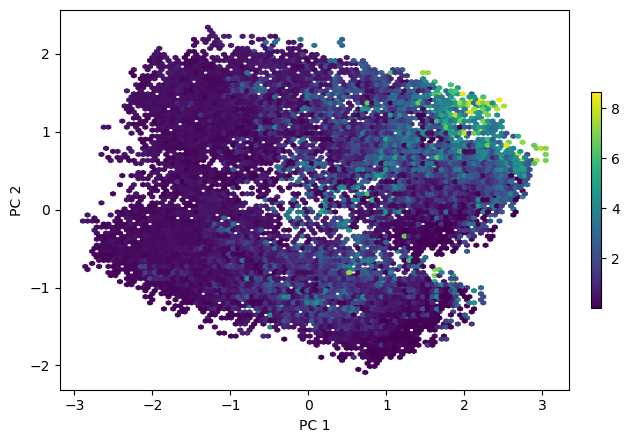

In [8]:
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')
plt.show()

In [9]:
unique_ids = []

for i in range(len(all_positions_cluster)):
    ids_acquired = all_positions_cluster[i]
    for j in all_positions_cluster[i]:
        if j not in unique_ids:
            unique_ids.append(j)

for i in range(len(all_positions_particle)):
    ids_acquired = all_positions_particle[i]
    for j in all_positions_particle[i]:
        if j not in unique_ids:
            unique_ids.append(j)

print(unique_ids)

print("Black Box Function calls: ", len(unique_ids))
print("All_function_calls: ", len(all_function_calls))

[19669, 16198, 23513, 20271, 21158, 11411, 13120, 14215, 9203, 8912, 6283, 7199, 5525, 13734, 13790, 11695, 18255, 18310, 18436, 15283, 16635, 18882, 10737, 21500, 25232, 25353, 18982, 18712, 18319, 24848, 22313, 23442, 24286, 19268, 17460, 25075, 24364, 15386, 7534, 14099, 15201, 15287, 15265, 5774, 8697, 8939, 8677, 14227, 15653, 14349, 16889, 10873, 12163, 13017, 13030, 4202, 3864, 6091, 17588, 6582, 4374, 6822]
Black Box Function calls:  62
All_function_calls:  62


[[11695, 19669, 18255, 18255, 18255, 18255, 18255, 18255, 18255, 18255, 18255], [18255, 18255, 18310, 18255, 18255, 18255, 18255, 18255, 18255, 18255, 18255], [18436, 15283, 15283, 15283, 15283, 15283, 16635, 18255, 18882, 18255, 18255], [10737, 19669, 18310, 18255, 18255, 18255, 18255, 18255, 18255, 18255, 18255], [11695, 19669, 18255, 18255, 18255, 18255, 18255, 18255, 18255, 18255, 18255], [21500, 25232, 25353, 18982, 18712, 18982, 18319, 18982, 18982, 18982, 18982], [24848, 25353, 22313, 18982, 18982, 18982, 18982, 18982, 18982, 18982, 18982], [23442, 24286, 25353, 18982, 19268, 18982, 18319, 18982, 18982, 18982, 18982], [25353, 25353, 17460, 17460, 18982, 19268, 18982, 18982, 18982, 18982, 18982], [25075, 24364, 18982, 18982, 18982, 18982, 19268, 18982, 18982, 18982, 18982], [15386, 15386, 15386, 15386, 15386, 15386, 15386, 15386, 15386, 15386, 15386], [7534, 7534, 7534, 7534, 7534, 7534, 7534, 7534, 7534, 7534, 7534], [14099, 15201, 15287, 15287, 15265, 15265, 15287, 15287, 15287

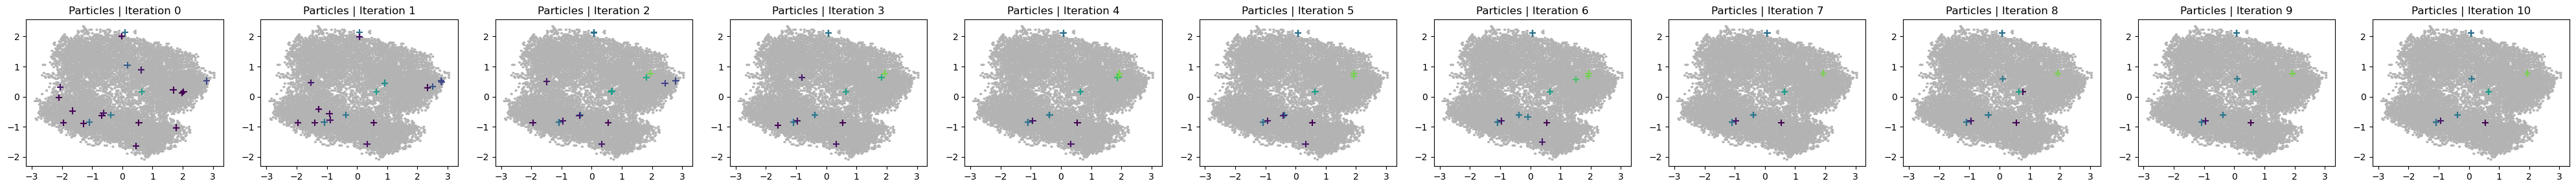

In [10]:
fig, ax = plt.subplots(1, len(all_positions_particle[0]), figsize=(40, 40))
fig.tight_layout()
print(all_positions_particle)


for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(y.shape[0]), cmap="binary", vmin=0, vmax=1)

for i in range(len(all_positions_particle[0])):
    ids_acquired = [id[i] for id in all_positions_particle]
    print(ids_acquired)
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Particles | Iteration {}'.format(i))

#plt.savefig("iterations_!.pdf", bbox_inches="tight")
plt.show()


[[10257, 7653, 7826, 7826, 7826, 7826, 7826, 7826, 7826, 7826, 7826], [20946, 20946, 20946, 18769, 18208, 12960, 12960, 12960, 12960, 12960, 12960], [14579, 14579, 16257, 16257, 16257, 16257, 16257, 16257, 16257, 16257, 16257], [12960, 12960, 12960, 12960, 12960, 17855, 17855, 17855, 17855, 17855, 17855], [10164, 12867, 12867, 19536, 20824, 20740, 20740, 20740, 20740, 20740, 20740]]
[10257, 20946, 14579, 12960, 10164]
[7653, 20946, 14579, 12960, 12867]
[7826, 20946, 16257, 12960, 12867]
[7826, 18769, 16257, 12960, 19536]
[7826, 18208, 16257, 12960, 20824]
[7826, 12960, 16257, 17855, 20740]
[7826, 12960, 16257, 17855, 20740]
[7826, 12960, 16257, 17855, 20740]
[7826, 12960, 16257, 17855, 20740]
[7826, 12960, 16257, 17855, 20740]
[7826, 12960, 16257, 17855, 20740]


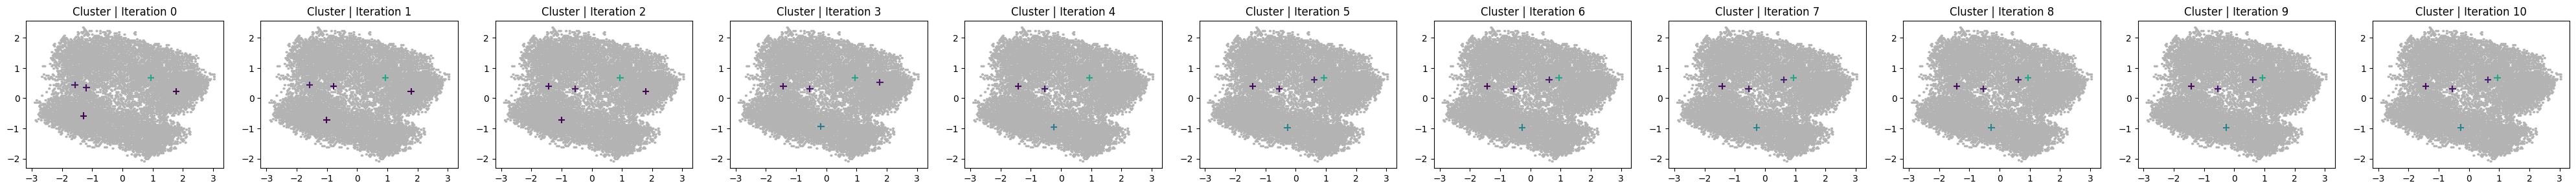

In [ ]:
fig, ax = plt.subplots(1, len(all_positions_cluster[0]), figsize=(40, 40))
fig.tight_layout()
print(all_positions_cluster)


for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(y.shape[0]), cmap="binary", vmin=0, vmax=1)

for i in range(len(all_positions_cluster[0])):
    ids_acquired = [id[i] for id in all_positions_cluster]
    print(ids_acquired)
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Cluster | Iteration {}'.format(i))

#plt.savefig("iterations_!.pdf", bbox_inches="tight")
plt.show()


[0.353140965, 0.353140965, 0.353140965, 0.423626528, 0.423626528, 1.963914222, 3.035468054, 3.035468054, 3.035468054, 3.035468054, 3.035468054, 3.035468054, 3.035468054, 3.035468054, 3.035468054, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 5.154759084, 7.289598332, 7.289598332, 7.289598332, 7.289598332, 7.289598332, 7.289598332, 7.289598332, 7.289598332, 7.289598332, 7.289598332, 7.6463566, 7.6463566, 7.6463566, 7.6463566, 7.6463566, 7.6463566, 7.6463566, 7.6463566, 7.6463566, 7.6463566, 7.6463566, 7.6463566, 7.6463566]


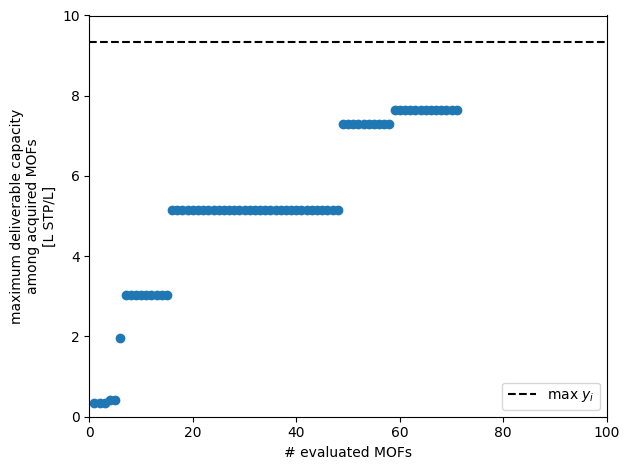

In [ ]:
x_values = np.arange(1, len(global_max_per_function_call) + 1)

print(global_max_per_function_call)

plt.figure()
plt.scatter(x_values, global_max_per_function_call)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
# We now have to run recursive PSO many times to find an average rate of optimization

import numpy as np
from sklearn.cluster import KMeans

# This will generate an approximate set of clusters of particles to use in Recursive PSO
def generate_clusters(arrays_list):
    arrays_matrix = np.array(arrays_list) # converting to a matrix so that we can use sklearn.kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0) # Creating a kmeans model
    kmeans.fit(arrays_matrix) # Training our model
    labels = kmeans.labels_ # We will use these labels to generate our clusters
    clusters = {i: [] for i in range(num_clusters)} # initializing our clusters array

    # Iterating through each label and assigning them to our clusters
    for idx, label in enumerate(labels):
        if (len(clusters[label]) < num_particles_in_cluster): # Esnures that we don't add more than num_particles_in_cluster particles to a cluster
            clusters[label].append(arrays_list[idx])

    # And we finally add some dummy particles to each cluster to ensure that each cluster has num_particles_in_cluster particles in them.
    for i in range(num_clusters):
        if (len(clusters[i]) < num_particles_in_cluster):
            for j in range(len(groups[i]), num_particles_in_cluster):
                clusters[i].append(groups[i][0])


    print("Cluster sizes: ")
    for j in range(num_clusters):
        print(len(clusters[j]))

    return clusters


num_clusters = 5
num_particles_in_cluster = 10
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w_cluster = 0.5
c1_cluster = 0.5
c2_cluster = 0.5
w_particle = 1.0
c1_particle = 1.0
c2_particle = 1.0
num_iterations = 10

arrays_list = random.choices(X, k=(num_clusters * num_particles_in_cluster))
clusters = generate_clusters(arrays_list)

initial_positions_PSO = []
for clust_index in range(num_clusters):
    initial_positions_PSO.append(clusters[clust_index])

print("Initial Positions: \n", initial_positions_PSO)

# num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, init_positions
pso = PSO(num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions_cluster, all_positions_particle, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions (Cluster): ", all_positions_cluster)
print("All_positions (Particle): ", all_positions_particle)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)
num_clusters = 5
num_particles_in_cluster = 10
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w_cluster = 0.5
c1_cluster = 0.5
c2_cluster = 0.5
w_particle = 1.0
c1_particle = 1.0
c2_particle = 1.0
num_iterations = 10

arrays_list = random.choices(X, k=(num_clusters * num_particles_in_cluster))
clusters = generate_clusters(arrays_list)

initial_positions_PSO = []
for clust_index in range(num_clusters):
    initial_positions_PSO.append(clusters[clust_index])

print("Initial Positions: \n", initial_positions_PSO)

# num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, init_positions
pso = PSO(num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions_cluster, all_positions_particle, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions (Cluster): ", all_positions_cluster)
print("All_positions (Particle): ", all_positions_particle)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster sizes: 
10
10
10
11
12
Initial Positions: 
 [[array([1.        , 0.00176788, 0.34217147, 0.10193408, 0.        ,
       0.00223703, 0.5       , 0.49731788, 0.52832179, 0.5623842 ,
       0.5752206 , 0.58366025, 0.17706093, 0.95698925, 0.37033708,
       0.97849462, 0.02150538, 0.07526882, 0.65133333, 0.88659794,
       0.58573099, 0.85148515, 0.        , 0.86      , 0.16151579,
       0.95101013, 0.35357177, 0.97542681, 0.02441668, 0.06169527,
       0.14781224, 0.74591952, 0.38702291, 0.7566284 , 0.01070888,
       0.01070888, 0.63529412, 0.88235294, 0.7       , 0.88235294,
       0.        , 0.88235294, 0.28888889, 0.83333333, 0.44      ,
       1.        , 0.16666667, 0.16666667, 0.29890454, 0.61032864,
       0.35889411, 0.77464789, 0.16431925, 0.16431925, 0.63134796,
       0.77115987, 0.53166144, 0.830721  , 0.05956113, 0.830721  ,
       0.84888889, 0.5       , 0.39111111, 1.        , 0.5       ,
       1.        , 0.44444444, 0.66666667, 0.71111111, 0.66666667,
       0

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best position found:  [1.         0.00239565 0.35378363 0.21939449 0.         0.00227895
 0.5        0.41803038 0.44058674 0.47541232 0.49031169 0.50039355
 0.27311828 0.55913978 0.35865169 0.58064516 0.02150538 0.17204301
 0.64       0.95876289 0.77473684 0.92079208 0.         0.93
 0.24289209 0.51838917 0.34399999 0.54280585 0.02441668 0.14175385
 0.06238189 0.074059   0.05096672 0.11543217 0.04137317 0.04137317
 0.63529412 0.94117647 0.81       0.94117647 0.         0.94117647
 0.45       0.66666667 0.4425     0.83333333 0.16666667 0.33333333
 0.49765258 0.66666667 0.41126761 1.         0.33333333 0.33333333
 0.48275862 0.74294671 0.62445141 0.74294671 0.         0.74294671
 0.83       0.5        0.42       1.         0.5        1.
 0.51666667 0.83333333 0.912      0.83333333 0.         0.83333333
 0.1        1.         0.36       1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.17142857 0.42857143 0.20571429 0.42857143 0.         0.21428571
 0.

In [11]:
def objective_function(x):
    x = np.array(x)

    # Finding the closest data point in the dataset
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    return y[closest_index]

# snap_position essentially snaps the input to the point in the database closest to it
def snap_position(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    snapped_input = X[closest_index]
    return snapped_input

def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

class Particle:
    def __init__(self, num_dimensions, lower_bound, upper_bound, init_position, index):
        self.position = init_position
        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = objective_function(self.best_position)
        self.index = index
        self.positions_traversed = [closest_index(init_position)]

class Cluster:
    def __init__(self, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, cluster_index, init_particle_positions, w_particle, c1_particle, c2_particle):
        self.particles = [Particle(num_dimensions, lower_bound, upper_bound, init_particle_positions[ind], ind) for ind in range(num_particles_in_cluster)]

        # Initial Position of the cluster is the average of the positions of all of the particles within that cluster
        init_cluster_position = np.zeros(num_dimensions)
        for particle in self.particles:
            init_cluster_position = np.add(init_cluster_position, particle.position)

        init_cluster_position = (init_cluster_position / num_particles_in_cluster)
        self.position = init_cluster_position

        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = y[closest_index(self.best_position)]

        # To determine the best particle within the cluster:

        self.in_cluster_best_position = self.particles[0].position
        for particle in self.particles:
            if( objective_function(particle.position) > objective_function(self.in_cluster_best_position) ):
                self.in_cluster_best_position = particle.position

        #self.in_cluster_best_position will now have the best particle within the cluster's position
        self.in_cluster_best_fitness = objective_function(self.in_cluster_best_position)

        self.w_particle = w_particle
        self.c1_particle = c1_particle
        self.c2_particle = c2_particle

        self.index = cluster_index

        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        self.positions_traversed = [closest_index(self.position)]

    def update_particles(self):
        for particle in self.particles:
            # Update velocities
            particle.velocity = (self.w_particle * particle.velocity
                                 + self.c1_particle * (particle.best_position - particle.position)
                                 + self.c2_particle * (self.in_cluster_best_position - particle.position))

            if(np.linalg.norm(particle.velocity) > 1.5):
                #print("old norm: ", np.linalg.norm(particle.velocity))
                particle.velocity = ((particle.velocity / np.linalg.norm(particle.velocity)) * 1.5)
                #print("new norm: ", np.linalg.norm(particle.velocity))

            particle.position = particle.position + particle.velocity + self.velocity # We need to move the particles along with the cluster too!

            particle.position = np.clip(particle.position, self.lower_bound, self.upper_bound)
            particle.position = snap_position(particle.position)
            particle.positions_traversed.append(closest_index(particle.position))

    def update_bests_particle(self):
        for particle in self.particles:
            current_fitness = objective_function(particle.position)

            if current_fitness > particle.best_fitness:
                particle.best_position = np.copy(particle.position)
                particle.best_fitness = current_fitness

                if current_fitness > self.in_cluster_best_fitness:
                    self.in_cluster_best_position = np.copy(particle.position)
                    self.in_cluster_best_fitness = current_fitness



class PSO:
    def __init__(self, num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, init_positions):
        self.num_clusters = num_clusters
        self.num_dimensions = num_dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.w_cluster = w_cluster
        self.c1_cluster = c1_cluster
        self.c2_cluster= c2_cluster
        self.num_iterations = num_iterations
        # def __init__(self, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, cluster_index, init_particle_positions, w_particle, c1_particle, c2_particle):
        self.clusters = [Cluster(num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, ind, init_positions[ind], w_particle, c1_particle, c2_particle) for ind in range(num_clusters)]

        self.global_best_cluster_position = self.clusters[0].position
        self.global_best_cluster_fitness = 0.0

        for cluster in self.clusters:
            if( y[closest_index(cluster.position)] > y[closest_index(self.global_best_cluster_position)] ):
                self.global_best_cluster_position = cluster.position

        self.global_best_cluster_fitness = y[closest_index(self.global_best_cluster_position)]

        self.global_best_position = np.zeros(num_dimensions)
        self.global_best_fitness = 0.0

        self.unique_function_call_ids = []
        self.global_max_for_each_unique_function_call = []

    def update_clusters(self):
        for cluster in self.clusters:

            # Update velocities
            cluster.velocity = (self.w_cluster * cluster.velocity
                                 + self.c1_cluster * np.random.rand() * (cluster.best_position - cluster.position)
                                 + self.c2_cluster * np.random.rand() * (self.global_best_cluster_position - cluster.position))

            if(np.linalg.norm(cluster.velocity) > 1.5):
                cluster.velocity = ((cluster.velocity / np.linalg.norm(cluster.velocity)) * 1.5)

            #print("cluster.velocity: ", cluster.velocity)
            cluster.position = cluster.position + cluster.velocity

            cluster.position = np.clip(cluster.position, self.lower_bound, self.upper_bound)
            cluster.position = snap_position(cluster.position)
            cluster.positions_traversed.append(closest_index(cluster.position))

    def update_bests_cluster(self):
        # Updating each individual cluster's information
        for cluster in self.clusters:
            current_fitness = y[closest_index(cluster.position)]

            if current_fitness > cluster.best_fitness:
                cluster.best_position = np.copy(cluster.position)
                cluster.best_fitness = current_fitness

                if current_fitness > self.global_best_cluster_fitness:
                    self.global_best_cluster_position = np.copy(cluster.position)
                    self.global_best_cluster_fitness = current_fitness


    def update_global_bests(self):
        for cluster in self.clusters:
            if( y[closest_index(cluster.position)] > y[closest_index(self.global_best_position)] ):
                self.global_best_position = cluster.position

            for particle in cluster.particles:
                if( y[closest_index(particle.position)] > y[closest_index(self.global_best_position)] ):
                    self.global_best_position = particle.position

        self.global_best_fitness = y[closest_index(self.global_best_position)]

    def update_unique_function_call_ids(self):
        for cluster in self.clusters:
            if closest_index(cluster.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(cluster.position))

            for particle in cluster.particles:
                if closest_index(particle.position) not in self.unique_function_call_ids:
                    self.unique_function_call_ids.append(closest_index(particle.position))

    def generate_global_max_for_each_unique_function_call(self):
        self.global_max_for_each_unique_function_call.append(y[self.unique_function_call_ids[0]])
        for i in range(1, len(self.unique_function_call_ids)):
            if( y[self.unique_function_call_ids[i]] > self.global_max_for_each_unique_function_call[ (i - 1) ] ):
                self.global_max_for_each_unique_function_call.append(y[self.unique_function_call_ids[i]])
            else:
                self.global_max_for_each_unique_function_call.append(self.global_max_for_each_unique_function_call[ (i - 1) ])


    def optimize(self):
      #for particle in self.particles:
        #   if closest_index(particle.position) not in self.unique_function_call_ids:
        #        self.unique_function_call_ids.append(closest_index(particle.position))
        #    if particle.best_fitness > self.global_best_fitness:
        #        self.global_best_position = np.copy(particle.position)
        #        self.global_best_fitness = particle.best_fitness
        #        self.global_max_for_each_unique_function_call.append(self.global_best_fitness)
        self.update_unique_function_call_ids()
        for i in range(self.num_iterations):

            self.update_clusters()
            self.update_bests_cluster()
            for cluster in self.clusters:
                cluster.update_particles()
                cluster.update_bests_particle()

            self.update_global_bests()
            self.update_unique_function_call_ids()


        all_positions_traversed_particles = []
        all_positions_traversed_clusters = []

        for cluster in self.clusters:
            all_positions_traversed_clusters.append(cluster.positions_traversed)
            for particle in cluster.particles:
                all_positions_traversed_particles.append(particle.positions_traversed)

        self.generate_global_max_for_each_unique_function_call()

        return self.global_best_position, self.global_best_fitness, all_positions_traversed_clusters, all_positions_traversed_particles, self.unique_function_call_ids, self.global_max_for_each_unique_function_call

import numpy as np
from sklearn.cluster import KMeans

# This will generate an approximate set of clusters of particles to use in Recursive PSO
def generate_clusters(arrays_list):
    arrays_matrix = np.array(arrays_list) # converting to a matrix so that we can use sklearn.kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0) # Creating a kmeans model
    kmeans.fit(arrays_matrix) # Training our model
    labels = kmeans.labels_ # We will use these labels to generate our clusters
    clusters = {i: [] for i in range(num_clusters)} # initializing our clusters array

    # Iterating through each label and assigning them to our clusters
    for idx, label in enumerate(labels):
        if (len(clusters[label]) < num_particles_in_cluster): # Esnures that we don't add more than num_particles_in_cluster particles to a cluster
            clusters[label].append(arrays_list[idx])

    # And we finally add some dummy particles to each cluster to ensure that each cluster has num_particles_in_cluster particles in them.
    for i in range(num_clusters):
        if (len(clusters[i]) < num_particles_in_cluster):
            for j in range(len(clusters[i]), num_particles_in_cluster):
                clusters[i].append(clusters[i][0])


    print("Cluster sizes: ")
    for j in range(num_clusters):
        print(len(clusters[j]))

    return clusters

import time # We will be measuring the time required for each iteration of recPSO

num_clusters = 5
num_particles_in_cluster = 10
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w_cluster = 0.5
c1_cluster = 0.5
c2_cluster = 0.5
w_particle = 1.0
c1_particle = 1.0
c2_particle = 1.0
num_iterations = 10

nb_runs = 50  # Number of runs of this we're doing!
gmpfc_arr = []
apt_arr = []
time_elapsed_per_run = []

for run_no in range(nb_runs):
    print("Run No.: ", run_no)
    
    start_time = time.time()

    # Generating our initial clusters
    arrays_list = random.choices(X, k=(num_clusters * num_particles_in_cluster))
    clusters = generate_clusters(arrays_list)
    initial_positions_PSO = []
    for clust_index in range(num_clusters):
        initial_positions_PSO.append(clusters[clust_index])
    #print("Initial Position for Run No. ", run_no, ": ", initial_positions_PSO)

    # Running Recursive PSO
    pso = PSO(num_clusters, num_particles_in_cluster, num_dimensions, lower_bound, upper_bound, w_cluster, c1_cluster, c2_cluster, w_particle, c1_particle, c2_particle, num_iterations, initial_positions_PSO)
    best_position, best_fitness, all_positions_cluster, all_positions_particle, all_function_calls, global_max_per_function_call = pso.optimize()
    
    end_time = time.time()
    elapsed_time = (end_time - start_time)
    print("Run #", run_no, " completed in ", elapsed_time, "seconds!")
    time_elapsed_per_run.append(elapsed_time)
    
    print("best_fitness for Run No. ", run_no, ": ", best_fitness)

    gmpfc_arr.append(global_max_per_function_call)
    apt_arr.append(all_function_calls)

print(gmpfc_arr)
print(apt_arr)
print(time_elapsed_per_run)

# Dumping this data into a .pkl file:
with open('rec_pso_graph_results.pkl', 'wb') as file:
  pickle.dump({'gmpfc_arr': gmpfc_arr, 'apt_arr': apt_arr, 'time_elapsed_per_run': time_elapsed_per_run}, file)

Run No.:  0
Cluster sizes: 
10
10
10
10
10
Run # 0  completed in  46.39783763885498 seconds!
best_fitness for Run No.  0 :  6.800264227
Run No.:  1
Cluster sizes: 
10
10
10
10
10
Run # 1  completed in  45.348422050476074 seconds!
best_fitness for Run No.  1 :  6.901751412
Run No.:  2
Cluster sizes: 
10
10
10
10
10
Run # 2  completed in  45.23868203163147 seconds!
best_fitness for Run No.  2 :  6.605729978
Run No.:  3
Cluster sizes: 
10
10
10
10
10
Run # 3  completed in  45.1191520690918 seconds!
best_fitness for Run No.  3 :  7.840250286
Run No.:  4
Cluster sizes: 
10
10
10
10
10
Run # 4  completed in  45.36424136161804 seconds!
best_fitness for Run No.  4 :  7.16868974
Run No.:  5
Cluster sizes: 
10
10
10
10
10
Run # 5  completed in  45.157968521118164 seconds!
best_fitness for Run No.  5 :  7.639193888
Run No.:  6
Cluster sizes: 
10
10
10
10
10
Run # 6  completed in  45.91609334945679 seconds!
best_fitness for Run No.  6 :  8.679211972
Run No.:  7
Cluster sizes: 
10
10
10
10
10
Run #

In [ ]:
# Dumping this data into a .pkl file:
with open('rec_pso_graph_results.pkl', 'wb') as file:
  pickle.dump({'gmpfc_arr': gmpfc_arr, 'apt_arr': apt_arr}, file)

In [ ]:
gmpfc_arr = pickle.load(open('rec_pso_graph_results.pkl', 'rb'))['gmpfc_arr']
apt_arr = pickle.load(open('rec_pso_graph_results.pkl', 'rb'))['apt_arr']

In [ ]:
num_iterations_per_run = []
for i in range(len(gmpfc_arr)):
    num_iterations_per_run.append(len(gmpfc_arr[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[110, 110, 142, 138, 129, 153, 101, 134, 156, 136, 145, 114, 140, 147, 154, 116, 152, 122, 131, 129, 120, 137, 125, 167, 139, 148, 145, 113, 126, 150, 117, 100, 152, 167, 138, 144, 117, 138, 160, 166, 145, 143, 166, 109, 141, 122, 140, 138, 141, 123]
167


In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(max_num_iterations):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes.append(gmpfc_arr[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [0.368648591, 0.000693359, 0.184344416, 0.704545106, 0.157940711, 0.004978738, 0.413548725, 0.376108951, 5.248692954, 2.358273019, 0.013402247, 2.492846436, 0.122805993, 0.00746973, 0.394462616, 0.153745945, 0.377254191, 2.467021468, 0.447078113, 0.423571642, 0.624234522, 0.368648591, 4.165108376, 0.004978738, 0.007362299, 4.145266886, 0.004978738, 0.027819498, 0.351251958, 0.401149571, 0.004978738, 0.359611835, 0.468503675, 0.213192609, 4.238161134, 0.000766922, 0.004978738, 0.021430627, 0.362912857, 0.136372295, 0.044237873, 4.653914864, 0.362423632, 0.611757427, 0.401149571, 0.024743557, 7.983094973, 0.599889014, 0.362195313, 0.495780795]
y_max_mu[i]:  0.96336657154
y_maxes < y_max_mu[i]:  [ True  True  True  True  True  True  True  True False False  True False
  True  True  True  True  True False  True  True  True  True False  True
  True False  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True False  True  True  T

In [ ]:
np_y_max_mu = np.array(y_max_mu)
np_y_max_sig_bot = np.array(y_max_sig_bot)
np_y_max_sig_top = np.array(y_max_sig_top)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167]


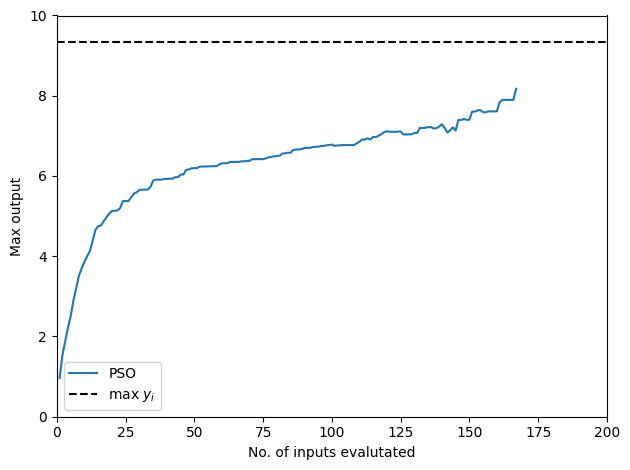

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu - np_y_max_sig_bot, np_y_max_mu + np_y_max_sig_top, alpha=0.2, ec="None")

plt.xlabel('No. of inputs evalutated')
plt.ylabel('Max output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 200])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
#plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
# We're going to "fix" the non-monotonicity of the PSO graph now, by adding dummy samples
gmpfc_arr_fixed = (pickle.load ( open ( 'rec_pso_graph_results.pkl', 'rb' ) ) [ 'gmpfc_arr' ] )
apt_arr_fixed = (pickle.load(open('rec_pso_graph_results.pkl', 'rb'))['apt_arr'])

In [ ]:
num_iterations_per_run = []
for i in range(50):
    num_iterations_per_run.append(len(gmpfc_arr_fixed[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[110, 110, 142, 138, 129, 153, 101, 134, 156, 136, 145, 114, 140, 147, 154, 116, 152, 122, 131, 129, 120, 137, 125, 167, 139, 148, 145, 113, 126, 150, 117, 100, 152, 167, 138, 144, 117, 138, 160, 166, 145, 143, 166, 109, 141, 122, 140, 138, 141, 123]
167


In [ ]:
for i in range(50):
    if (len(gmpfc_arr_fixed[i]) < max_num_iterations):
        for j in range(max_num_iterations - len(gmpfc_arr_fixed[i])):
            gmpfc_arr_fixed[i].append(gmpfc_arr_fixed[i][len(gmpfc_arr_fixed[i]) - 1])


In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu_fixed = []
y_max_sig_bot_fixed = []
y_max_sig_top_fixed = []

for i in range(max_num_iterations):
    y_maxes_fixed = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr_fixed[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes_fixed.append(gmpfc_arr_fixed[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes_fixed)
    y_max_mu_fixed.append( np.mean(y_maxes_fixed) )
    print("y_max_mu_fixed[i]: ", y_max_mu_fixed[i])
    print("y_maxes_fixed < y_max_mu_fixed[i]: ", y_maxes_fixed < y_max_mu_fixed[i])

    y_maxes_L_y_max_mu_i_fixed = y_maxes_fixed < y_max_mu_fixed[i]
    y_max_sig_bot_temp_fixed = []
    for k in range(len(y_maxes_L_y_max_mu_i_fixed)):
        if (y_maxes_L_y_max_mu_i_fixed[k] == True):
            y_max_sig_bot_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_bot_fixed.append( np.std ( y_max_sig_bot_temp_fixed )  )
    print(y_max_sig_bot_fixed[i])

    y_maxes_G_y_max_mu_i_fixed = y_maxes_fixed > y_max_mu_fixed[i]
    y_max_sig_top_temp_fixed = []
    for k in range(len(y_maxes_G_y_max_mu_i_fixed)):
        if (y_maxes_G_y_max_mu_i_fixed[k] == True):
            y_max_sig_top_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_top_fixed.append( np.std ( y_max_sig_top_temp_fixed )  )
    print(y_max_sig_top_fixed[i])

print("y_max_mu_fixed: ", y_max_mu_fixed)
print("y_max_sig_bot_fixed: ", y_max_sig_bot_fixed)
print("y_max_sig_top_fixed: ", y_max_sig_top_fixed)


y_maxes for iteration  0 :  [0.368648591, 0.000693359, 0.184344416, 0.704545106, 0.157940711, 0.004978738, 0.413548725, 0.376108951, 5.248692954, 2.358273019, 0.013402247, 2.492846436, 0.122805993, 0.00746973, 0.394462616, 0.153745945, 0.377254191, 2.467021468, 0.447078113, 0.423571642, 0.624234522, 0.368648591, 4.165108376, 0.004978738, 0.007362299, 4.145266886, 0.004978738, 0.027819498, 0.351251958, 0.401149571, 0.004978738, 0.359611835, 0.468503675, 0.213192609, 4.238161134, 0.000766922, 0.004978738, 0.021430627, 0.362912857, 0.136372295, 0.044237873, 4.653914864, 0.362423632, 0.611757427, 0.401149571, 0.024743557, 7.983094973, 0.599889014, 0.362195313, 0.495780795]
y_max_mu_fixed[i]:  0.96336657154
y_maxes_fixed < y_max_mu_fixed[i]:  [ True  True  True  True  True  True  True  True False False  True False
  True  True  True  True  True False  True  True  True  True False  True
  True False  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True Fa

In [ ]:
np_y_max_mu_fixed = np.array(y_max_mu_fixed)
np_y_max_sig_bot_fixed = np.array(y_max_sig_bot_fixed)
np_y_max_sig_top_fixed = np.array(y_max_sig_top_fixed)


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167]


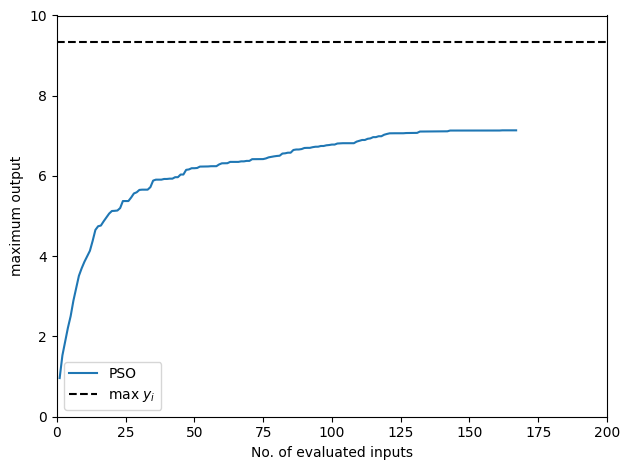

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu_fixed, label="recPSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu_fixed - np_y_max_sig_bot_fixed, np_y_max_mu_fixed + np_y_max_sig_top_fixed, alpha=0.2, ec="None")

plt.xlabel('No. of evaluated inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 200])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
#plt.savefig("search_efficiency_for_specific_acquisition_run_fixed.pdf")
plt.show()

In [ ]:
# Let's plot everything on a single graph to compare:

In [ ]:
# Recursive PSO (this notebook; just makes it simpler to keep track of everything)
gmpfc_arr_recpso = []
apt_arr_recpso = []

gmpfc_arr_recpso = (pickle.load ( open ( 'rec_pso_graph_results.pkl', 'rb' ) ) [ 'gmpfc_arr' ] )
apt_arr_recpso = (pickle.load(open('rec_pso_graph_results.pkl', 'rb'))['apt_arr'])

num_iterations_per_run = []
for i in range(50):
    num_iterations_per_run.append(len(gmpfc_arr_recpso[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[110, 110, 142, 138, 129, 153, 101, 134, 156, 136, 145, 114, 140, 147, 154, 116, 152, 122, 131, 129, 120, 137, 125, 167, 139, 148, 145, 113, 126, 150, 117, 100, 152, 167, 138, 144, 117, 138, 160, 166, 145, 143, 166, 109, 141, 122, 140, 138, 141, 123]
167


In [ ]:
for i in range(50):
    if (len(gmpfc_arr_recpso[i]) < max_num_iterations):
        for j in range(max_num_iterations - len(gmpfc_arr_recpso[i])):
            gmpfc_arr_recpso[i].append(gmpfc_arr_recpso[i][len(gmpfc_arr_recpso[i]) - 1])


In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu_fixed_recpso = []
y_max_sig_bot_fixed_recpso = []
y_max_sig_top_fixed_recpso = []

for i in range(max_num_iterations):
    y_maxes_fixed = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr_recpso[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes_fixed.append(gmpfc_arr_recpso[j][i])

    #print("y_maxes for iteration ", i, ": ", y_maxes_fixed)
    y_max_mu_fixed_recpso.append( np.mean(y_maxes_fixed) )
    #print("y_max_mu_fixed[i]: ", y_max_mu_fixed_recpso[i])
    #print("y_maxes_fixed < y_max_mu_fixed[i]: ", y_maxes_fixed < y_max_mu_fixed_recpso[i])

    y_maxes_L_y_max_mu_i_fixed = y_maxes_fixed < y_max_mu_fixed_recpso[i]
    y_max_sig_bot_temp_fixed = []
    for k in range(len(y_maxes_L_y_max_mu_i_fixed)):
        if (y_maxes_L_y_max_mu_i_fixed[k] == True):
            y_max_sig_bot_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_bot_fixed_recpso.append( np.std ( y_max_sig_bot_temp_fixed )  )
    #print(y_max_sig_bot_fixed_recpso[i])

    y_maxes_G_y_max_mu_i_fixed = y_maxes_fixed > y_max_mu_fixed_recpso[i]
    y_max_sig_top_temp_fixed = []
    for k in range(len(y_maxes_G_y_max_mu_i_fixed)):
        if (y_maxes_G_y_max_mu_i_fixed[k] == True):
            y_max_sig_top_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_top_fixed_recpso.append( np.std ( y_max_sig_top_temp_fixed )  )
    #print(y_max_sig_top_fixed_recpso[i])

#print("y_max_mu_fixed: ", y_max_mu_fixed_recpso)
#print("y_max_sig_bot_fixed: ", y_max_sig_bot_fixed_recpso)
#print("y_max_sig_top_fixed: ", y_max_sig_top_fixed_recpso)


In [ ]:
# Bayesian Optimization
max_per_function_call_arr_bo = []
ids_acquired_arr_bo = []

max_per_function_call_arr_bo = (pickle.load ( open ( 'bo_results.pkl', 'rb' ) ) [ 'max_per_function_call_arr' ] )
ids_acquired_arr_bo = (pickle.load ( open ( 'bo_results.pkl', 'rb' ) ) [ 'ids_acquired_arr' ] )

In [ ]:
# Generating the arrays we will use to plot our final figures:

nb_runs = 50

y_max_mu_bo = []
y_max_sig_bot_bo = []
y_max_sig_top_bo = []

for i in range(nb_runs):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(max_per_function_call_arr_bo[j]) ): #only if max_per_function_call_arr[j] has ith iteration!
              y_maxes.append(max_per_function_call_arr_bo[j][i])

    #print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu_bo.append( np.mean(y_maxes) )
    #print("y_max_mu[i]: ", y_max_mu[i])
    #print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu_bo[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu_bo[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot_bo.append( np.std ( y_max_sig_bot_temp )  )
    #print(y_max_sig_bot_bo[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu_bo[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top_bo.append( np.std ( y_max_sig_top_temp )  )
    #print(y_max_sig_top_bo[i])

#print("y_max_mu: ", y_max_mu_bo)
#print("y_max_sig_bot: ", y_max_sig_bot_bo)
#print("y_max_sig_top: ", y_max_sig_top_bo)


In [ ]:
# standard EPSO
y_max_mu_fixed_epso = []
y_max_sig_bot_fixed_epso = []
y_max_sig_top_fixed_epso = []

y_max_mu_fixed_epso = (pickle.load ( open ( 'epso_graph_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_mu_epso_fixed' ] )
y_max_sig_bot_fixed_epso = (pickle.load ( open ( 'epso_graph_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_sig_bot_epso_fixed' ] )
y_max_sig_top_fixed_epso = (pickle.load ( open ( 'epso_graph_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_sig_top_epso_fixed' ] )

In [ ]:
# standard PSO
y_max_mu_fixed_pso = []
y_max_sig_bot_fixed_pso = []
y_max_sig_top_fixed_pso = []

y_max_mu_fixed_pso = (pickle.load ( open ( 'pso_graph_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_mu_pso_fixed' ] )
y_max_sig_bot_fixed_pso = (pickle.load ( open ( 'pso_graph_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_sig_bot_pso_fixed' ] )
y_max_sig_top_fixed_pso = (pickle.load ( open ( 'pso_graph_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_sig_top_pso_fixed' ] )

In [ ]:
# recursive EPSO
y_max_mu_fixed_rec_epso = []
y_max_sig_bot_fixed_rec_epso = []
y_max_sig_top_fixed_rec_epso = []

y_max_mu_fixed_rec_epso = (pickle.load ( open ( 'rec_epso_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_mu_fixed_rec_epso' ] )
y_max_sig_bot_fixed_rec_epso = (pickle.load ( open ( 'rec_epso_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_sig_bot_fixed_rec_epso' ] )
y_max_sig_top_fixed_rec_epso = (pickle.load ( open ( 'rec_epso_outputs_fixed.pkl', 'rb' ) ) [ 'y_max_sig_top_fixed_rec_epso' ] )

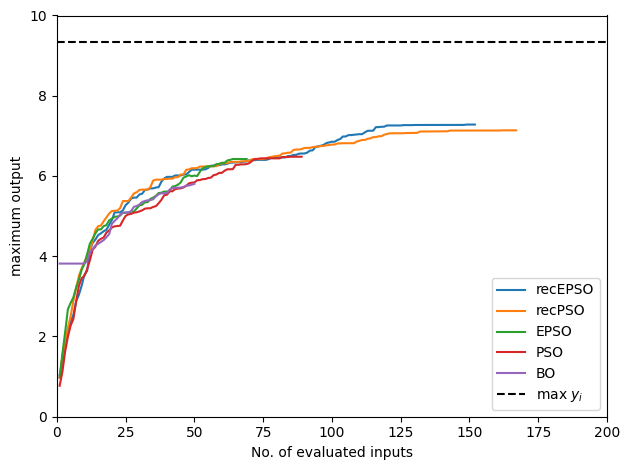

In [ ]:
x_values_rec_pso = np.arange(1, len(y_max_mu_fixed_recpso) + 1)
x_values_rec_epso = np.arange(1, len(y_max_mu_fixed_rec_epso) + 1)
x_values_epso = np.arange(1, len(y_max_mu_fixed_epso) + 1)
x_values_pso = np.arange(1, len(y_max_mu_fixed_pso) + 1)
x_values_bo = np.arange(1, 51)


plt.figure()
plt.plot(x_values_rec_epso, y_max_mu_fixed_rec_epso, label="recEPSO", clip_on=False)
plt.plot(x_values_rec_pso, y_max_mu_fixed_recpso, label="recPSO", clip_on=False)
plt.plot(x_values_epso, y_max_mu_fixed_epso, label="EPSO", clip_on=False)
plt.plot(x_values_pso, y_max_mu_fixed_pso, label="PSO", clip_on=False)
plt.plot(x_values_bo, y_max_mu_bo, label="BO", clip_on=False)


plt.xlabel('No. of evaluated inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 200])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
#plt.savefig("search_efficiency_for_specific_acquisition_run_fixed.pdf")
plt.show()